In [1]:
!pip install transformers datasets
!pip install ultralytics
!pip install supervision

from IPython import display

display.clear_output()

In [21]:
import torch
import torchvision
from torchvision import transforms
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import supervision as sv
from ultralytics import YOLO
import ultralytics
import cv2

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CLIPModel.from_pretrained("FreddyFazbear0209/CLIP_for_visual_recognition").to(device)
processor = CLIPProcessor.from_pretrained("FreddyFazbear0209/CLIP_for_visual_recognition")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

In [7]:
yolo = YOLO('yolov8n.pt').to(device)

In [11]:
CLASS_NAMES_DICT = yolo.model.names
SELECTED_CLASS_NAMES = ['person']
SELECTED_CLASS_IDS = [{value: key for key, value in CLASS_NAMES_DICT.items()}[class_name] for class_name in SELECTED_CLASS_NAMES]

box_annotator = sv.BoxAnnotator(thickness=2)

label_annotator = sv.LabelAnnotator(
    text_thickness=1,
    text_scale=1,
    text_color=sv.Color.BLACK
)

In [32]:
def crop_images_from_detections(image, detections):
    cropped_images = []
    for det in detections:
        x_min, y_min, x_max, y_max = det  # [x_min, y_min, x_max, y_max, conf]
        x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])

        x_min = max(0, x_min)
        y_min = max(0, y_min)
        x_max = min(image.shape[1], x_max)
        y_max = min(image.shape[0], y_max)

        if x_max > x_min and y_max > y_min:
            cropped_image = image[y_min:y_max, x_min:x_max, :]
            cropped_images.append(cropped_image)
    return cropped_images


def preprocess_images(images):
    preprocess = transforms.Compose([
        transforms.ToTensor(),                       # (H,W,3) uint8 -> (3,H,W) float [0,1]
        transforms.Resize((224, 224)),               # resize về 224x224
        transforms.Normalize(                        # chuẩn hóa theo CLIP
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        )
    ])

    return preprocess(images)


def object_detection(yolo, path):
  frame = cv2.imread(path)

  results = yolo(frame, verbose=False)[0]
  detections = sv.Detections.from_ultralytics(results)
  detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]

  labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
  ]
  annotated_frame = frame.copy()

  annotated_frame = box_annotator.annotate(
    scene=annotated_frame,
    detections=detections
  )

  annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    labels=labels
  )

  return annotated_frame


def zero_shot_object_detection(yolo, clip, processor, text, path):
    frame = cv2.imread(path)

    results = yolo(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]

    cropped_images = crop_images_from_detections(frame, detections.xyxy)

    image_tensors = [preprocess_images(img) for img in cropped_images]
    image_tensors = torch.stack(image_tensors).to(device)


    text_inputs = processor(text=[text], return_tensors="pt", padding=True).to(device)

    with torch.no_grad():
        text_embeds = model.get_text_features(**text_inputs)
        image_embeds = model.get_image_features(pixel_values=image_tensors)

    image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
    text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)

    similarities = (text_embeds @ image_embeds.T).squeeze(0)

    max_idx = torch.argmax(similarities, dim=None, keepdim=False).item()
    detections_matched = detections[max_idx]

    annotated_frame = frame.copy()

    annotated_frame = box_annotator.annotate(
        scene=annotated_frame,
        detections=detections_matched
    )

    return annotated_frame

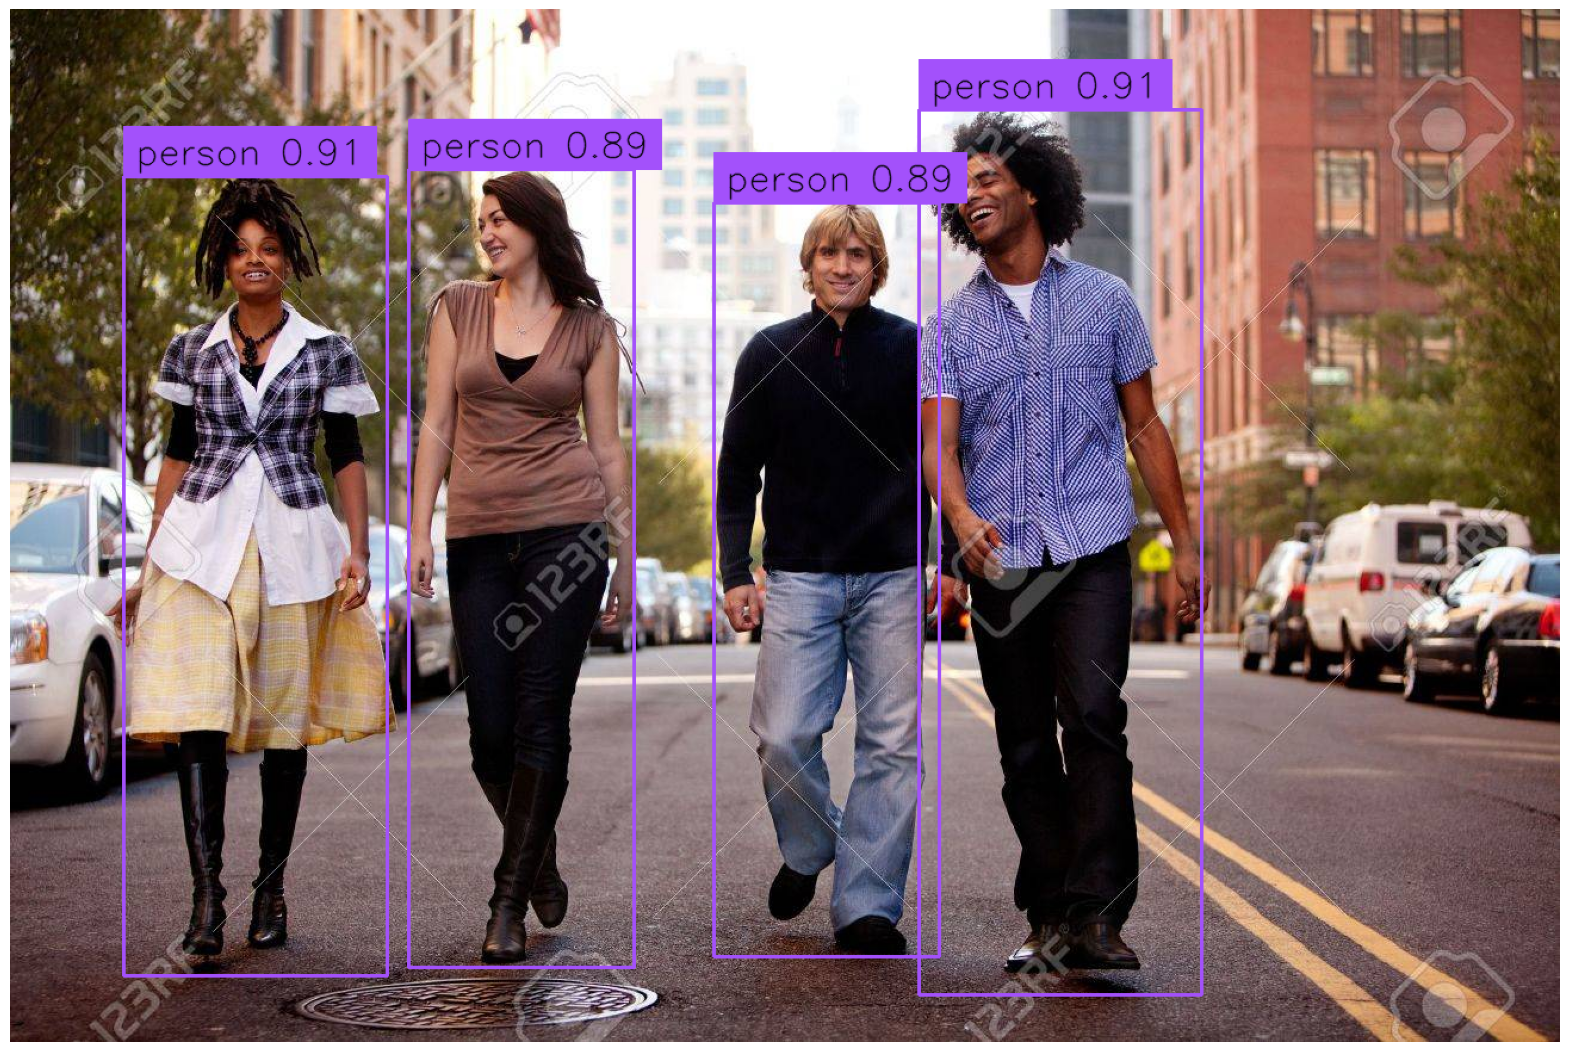

In [31]:
object_detection = object_detection(yolo, 'people_walking.jpg')
sv.plot_image(object_detection, (20, 20))

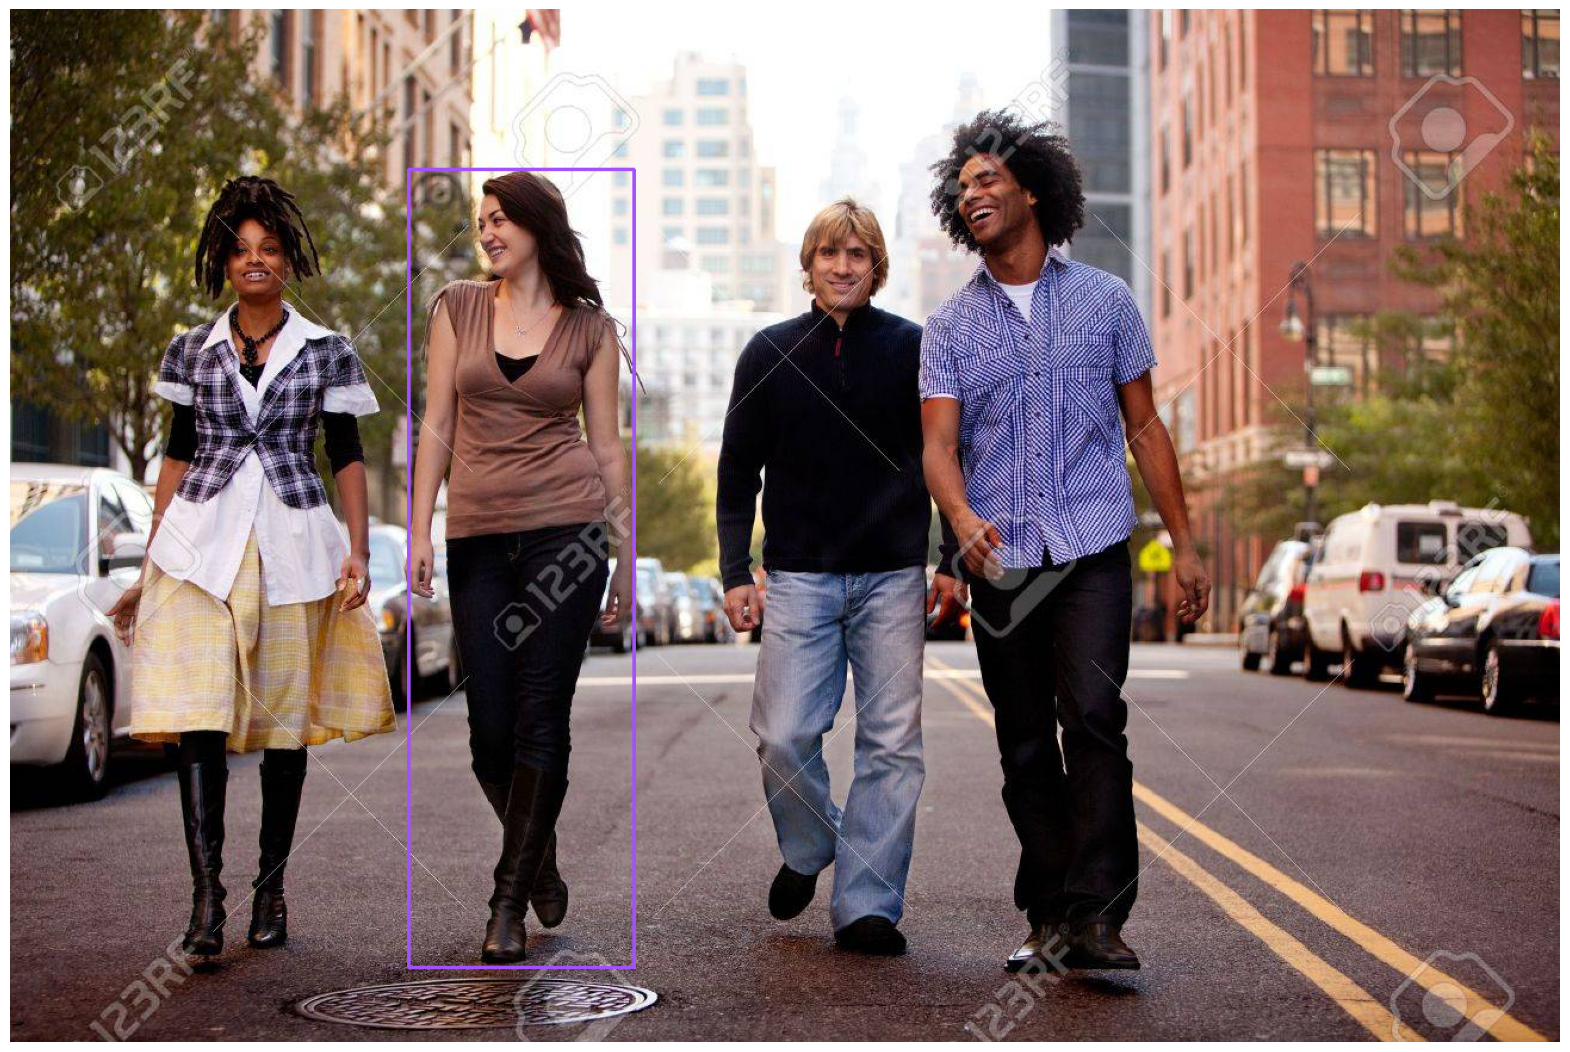

In [33]:
zerohost_object_detection = zero_shot_object_detection(yolo, model, processor, "woman, upper body wears brown shirt, short sleeve, lower body wears long black trousers", 'people_walking.jpg')
sv.plot_image(zerohost_object_detection, (20, 20))